# Load libraries 
for image processing we use skimage, for saving results pandas

In [2]:
%matplotlib inline

ncore = 8

import os
os.environ['KMP_AFFINITY'] = 'disabled'
os.environ['MKL_NUM_THREADS'] = str(ncore)

import numpy as np
import pandas as pd
from skimage.io import imread, imsave
from glob import glob
import matplotlib.pyplot as plt
from time import time

# Read in data
in this case a 3D tif stack of tomographic slices

In [3]:
# Set the data path
site_data_dir = '/data/staff/tomograms' # tomograms test data at MAX IV
#site_data_dir = '/projects/maxiv/staff/tomograms/test-data/' # tomograms test data at LUNARC

print("Site data root directory: %s" % site_data_dir)

Site data root directory: /data/staff/tomograms


In [4]:
!ls {site_data_dir}/test-data/imquant -lh

total 8.3G
-rw-rw-r-- 1 zdemat acc-tomograms-staff 2.8G Jul 14  2019 sample1_mid_0h_stack.tif
-rw-rw-r-- 1 zdemat acc-tomograms-staff 2.8G Jul 14  2019 sample1_mid_1h_stack.tif
-rw-rw-r-- 1 zdemat acc-tomograms-staff 2.8G Jul 14  2019 sample1_mid_2h_stack.tif


In [5]:
all_files = sorted(glob(site_data_dir+'/test-data/imquant/sample1_mid*stack.tif'))
print(len(all_files), all_files[0])
print(len(all_files), all_files[1])

3 /data/staff/tomograms/test-data/imquant/sample1_mid_0h_stack.tif
3 /data/staff/tomograms/test-data/imquant/sample1_mid_1h_stack.tif


In [6]:
stack_image = imread(all_files[1])

In [7]:
nhight, ncols, nrows = stack_image.shape
row, col = np.ogrid[:nrows, :ncols]
print(stack_image.shape, stack_image.dtype)

(1152, 1600, 1600) uint8


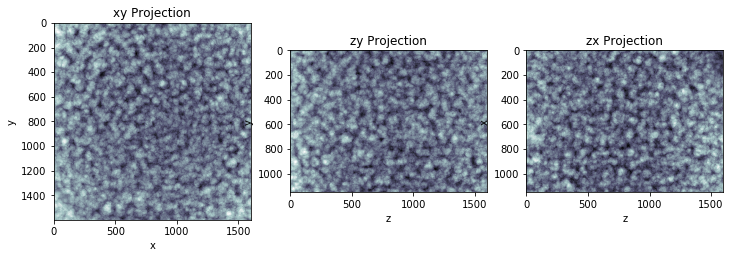

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 4))
for i, (cax, clabel) in enumerate(zip([ax1, ax2, ax3], ['xy', 'zy', 'zx'])):
    cax.imshow(np.sum(stack_image,i).squeeze(), interpolation='none', cmap = 'bone_r')
    cax.set_title('%s Projection' % clabel)
    cax.set_xlabel(clabel[0])
    cax.set_ylabel(clabel[1])

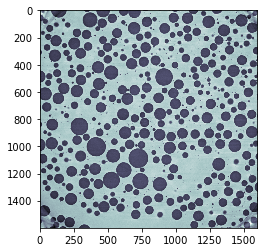

In [9]:
plt.imshow(stack_image[100],cmap='bone')

# Binarization

First remove extreme values from the image

In [10]:
#from scipy import stats
#vmin, vmax = stats.scoreatpercentile(stack_image, (0.5, 99.5))

In [11]:
# same as above, however faster
vmin, vmax = np.percentile(stack_image, (0.5, 99.5))

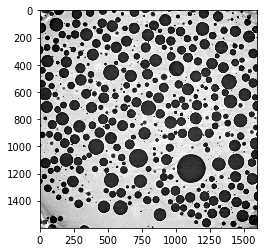

In [12]:
np.clip(stack_image, vmin, vmax, out=stack_image)
stack_image = (stack_image - np.float32(vmin)) / np.float32(vmax - vmin)
plt.imshow(stack_image[60], cmap='gray')

## Simple thresholding

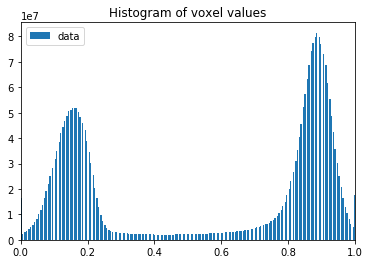

In [13]:
from skimage import exposure
hi_stack_image = exposure.histogram(stack_image)
plt.bar(hi_stack_image[1],hi_stack_image[0],width=hi_stack_image[1][1]-hi_stack_image[1][0],label='data')
plt.xlim(0, 1)
plt.legend()
plt.title('Histogram of voxel values');

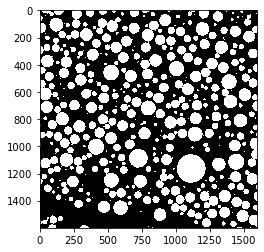

In [14]:
seg_stack_image = stack_image >0.4
seg_stack_image_inv = np.invert(seg_stack_image)
plt.imshow(seg_stack_image_inv[60],cmap='gray')

## Random walker segmentation

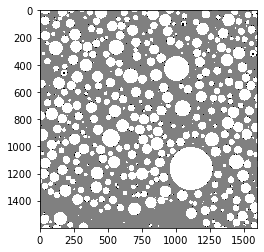

In [15]:
markers = np.zeros(stack_image.shape, dtype=np.uint8)
markers[stack_image > 0.4] = 1
markers[stack_image < 0.33] = 2
plt.imshow(markers[10], cmap='gray')

In [16]:
#from skimage import segmentation 
#rw = segmentation.random_walker(stack_image, markers, beta=np.float32(1000.), mode='cg_mg')
#plt.imshow(stack_image[10], cmap='gray')
#plt.contour(rw[10], [1.5])

In [17]:
sh = stack_image.shape
slab_halfheight = 16
stack_image_slab = stack_image[sh[0]//2-slab_halfheight:sh[0]//2+slab_halfheight,:,:] # slab
markers_slab = markers[sh[0]//2-slab_halfheight:sh[0]//2+slab_halfheight,:,:]

In [18]:
from skimage import segmentation

rw_slab = segmentation.random_walker(stack_image_slab, markers_slab, beta=1000., mode='cg_mg')

/opt/conda/envs/imquant/lib/python3.7/site-packages/skimage/segmentation/random_walker_segmentation.py:496: UserWarning: pyamg (http://pyamg.github.io/)) is needed to use
                this mode, but is not installed. The 'cg' mode will be used
                instead.
  instead.""")


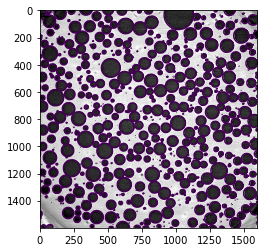

In [19]:
plt.imshow(stack_image_slab[10], cmap='gray')
plt.contour(rw_slab[10], [1.5])

In [20]:
#clean_segmentation = morphology.remove_small_objects(rw == 1, 200)

/opt/conda/envs/imquant/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


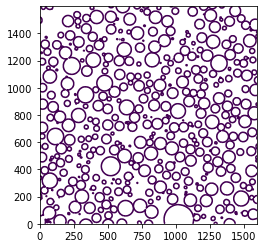

In [21]:
from skimage import morphology

clean_segmentation_slab = morphology.remove_small_objects(rw_slab == 2, 1000) # origin: 1, 200

plt.contour(clean_segmentation_slab[10], [1.5])
plt.axis('image');

# Create Bubble Image
The bubble image is the reverse of the plateau border image (where there is water there can't be air) with a convex hull used to find the mask of the image
$$ \text{Bubbles} = \text{ConvexHull}(\text{PlateauBorder}) - \text{PlateauBorder} $$

In [ ]:
from skimage.morphology import binary_opening, convex_hull_image as chull
bubble_image = np.stack([chull(csl>0) & (csl==0) for csl in seg_stack_image_inv])
plt.imshow(bubble_image[60]>0, cmap = 'bone')

In [ ]:
#bubble_invert=np.invert(bubble_image)
bubble_invert=seg_stack_image_inv
plt.imshow(bubble_invert[100],cmap='bone')

# Save binary image

In [ ]:
##from skimage import io
##import skimage.io._plugins.freeimage_plugin as fi
##seg_stack_imageS=seg_stack_image[100,300:600,300:600]
##seg_stack_imageS.shape
#fi.write(seg_stack_imageS,'sample1_binary.tif')
#from skimage.external import tifffile
#io.imsave('sample1_binary.tif',seg_stack_imageS,)
#import scipy.misc
#scipy.misc.imsave('temp.tiff', bubble_invert[100:,:])

#from matplotlib import pyplot
#tifffile.imshow(bubble_invert[100,:,:])
#tifffile.TiffWriter('sample1_bin.tif',bubble_invert)
#with tifffile.TiffWriter('temp.tif', bigtiff=True) as tif:
#    for i in range(bubble_invert.shape[0]):
#        tif.save(bubble_invert[i], compress=6)

# create distance map

In [1]:
from scipy import ndimage as ndi
from scipy.ndimage.morphology import distance_transform_edt as distmap
print(seg_stack_image_inv.shape)
#bubble_dist = distmap(seg_stack_image_inv)
#bubble_dist=distmap(bubble_invert)

NameError: name 'seg_stack_image_inv' is not defined

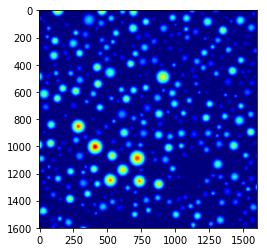

In [19]:
plt.imshow(bubble_dist[100,:,:],interpolation='none',cmap='jet')

# Calculate local maxima

In [20]:
from skimage.feature import peak_local_max
bubble_candidates=peak_local_max(bubble_dist,min_distance=12)
print('Found',len(bubble_candidates),'bubbles')

Found 35199 bubbles


In [21]:
df = pd.DataFrame(data=bubble_candidates, columns=['x','y','z'])
df.to_csv('./bubble.candidates_sample1_mid.csv')

# Watershed segmentation

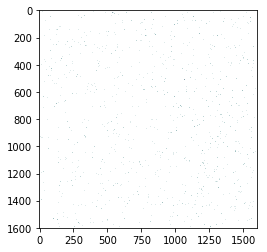

In [22]:
from skimage.morphology import watershed
bubble_seeds=peak_local_max(bubble_dist,min_distance=10, indices='false')
plt.imshow(np.sum(bubble_seeds,0).squeeze(),interpolation='none', cmap='bone_r')

In [23]:
markers = ndi.label(bubble_seeds)[0]
#cropped_markers = markers[50:450,50:450,50:450]
#cropped_bubble_dist=bubble_dist[50:450,50:450,50:450]
#cropped_bubble_inver=bubble_invert[50:450,50:450,50:450]
#labeled_bubbles= watershed(-bubble_dist, markers, mask=bubble_invert)
labeled_bubbles= watershed(-bubble_dist, markers, mask=seg_stack_image_inv)

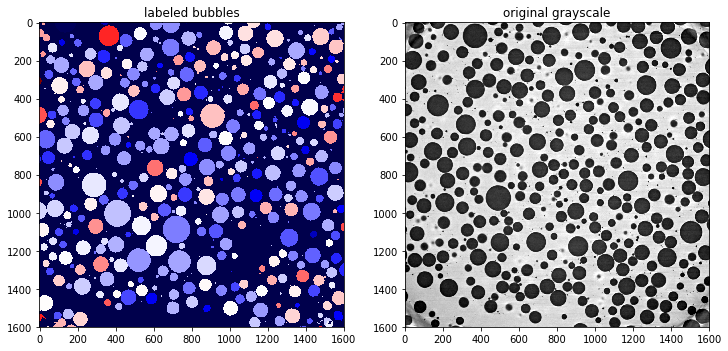

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.set_title('labeled bubbles')
ax1.imshow(labeled_bubbles[100,:,:], cmap=plt.cm.seismic, interpolation='nearest')
ax2.set_title('original grayscale')
ax2.imshow(stack_image[200,:,:], cmap='gray')

# Feature properties

In [25]:
from skimage.measure import regionprops
regions=regionprops(labeled_bubbles)
regions[40].filled_area
regions[40].centroid

(29.41234782133439, 939.6380381761788, 519.7602893956577)

# Save labeled image and properties

In [27]:
from tifffile import imsave
#image = np.zeros((32, 256, 256), 'uint16')
imsave('sample1_mid_labeled.tif', labeled_bubbles) 

ModuleNotFoundError: No module named 'tifffile'

In [28]:
#bubble volumes
bubble_volume=[prop.filled_area for prop in regions]
bubble_volume_mean=np.mean(bubble_volume)
dfV = pd.DataFrame(data=bubble_volume, columns=['volume [pix^3]'])
dfV.to_csv('./bubble_volumes_sample1_mid.csv')
Vm = {'mean volume': [1,bubble_volume_mean]}
dfVm=pd.DataFrame(data=Vm)

#liquid fraction
vols_image=nhight*ncols*nrows
vols_allbubbles=sum(bubble_volume)
liquid_fraction=1-vols_allbubbles/vols_image
print('liquid fraction = ',liquid_fraction)
LFcol = {'liquid fraction': [1,liquid_fraction]}
dfLF=pd.DataFrame(data=LFcol)

#BUBBLE Diameters
bubble_diameter=[prop.equivalent_diameter for prop in regions]
bubble_diameter_mean=np.mean(bubble_diameter)
print('mean bubble diameter [pixels] = ', bubble_diameter_mean)
dfD = pd.DataFrame(data=bubble_diameter, columns=['diameter [pix]'])
dfD.to_csv('./bubble_diameters_sample1_mid.csv')
Dm = {'mean diameter': [1,bubble_diameter_mean]}
dfDm=pd.DataFrame(data=Dm)

#BUBBLE CENTERS
bubble_centers=[prop.centroid for prop in regions]
#bubble_centers[1]
#all_properties = {'x': bubble_centers, 'volume' : bubble_volumes}
dfC = pd.DataFrame(data=bubble_centers, columns=['posX','posY','posZ'])
dfC.to_csv('./bubble_centroid_sample1_mid.csv')

liquid fraction =  0.601755116780599
mean bubble diameter [pixels] =  19.19822841134557


In [29]:
dfA = pd.concat([dfLF.round(2),dfV,dfVm.round(0),dfD.round(0),dfDm.round(0),dfC.round(0)], axis=1, join='outer', ignore_index=False)
dfA.to_csv('./bubble_props_sample1_mid.csv')
#columns = ["volume","diameter"] #a csv with 3 columns
#index = [i[0] for i in all_properties] #first element of every list in yourlist
#not_index_list = [i[1:] for i in all_properties]
#df = pd.DataFrame(not_index_list, columns = columns, index = index)
#Now you have a csv with columns and index:
#df.to_csv('./bubble_props_sample1_mid.csv')

Text(0.5, 1.0, 'radii  distribution')

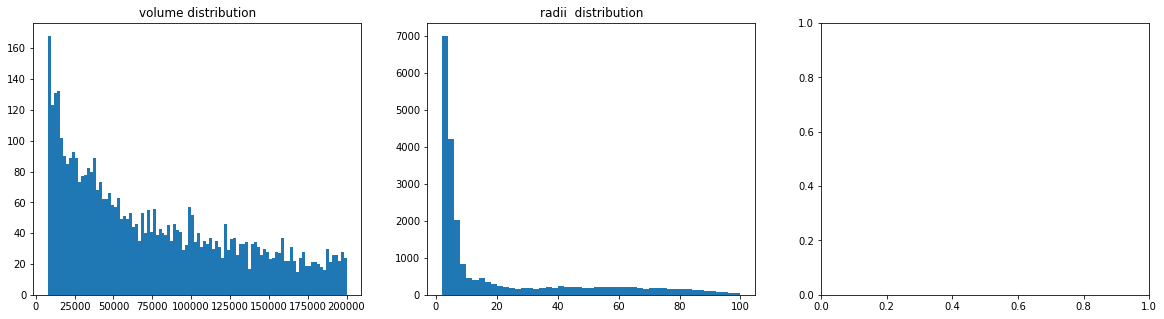

In [30]:
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(20,5))
ax1.hist(bubble_volume, bins=100, range = [8000,200000] )
ax1.set_title('volume distribution')
ax2.hist(bubble_diameter, np.linspace(2, 100, 50), label = 's1_mid_t0')
ax2.set_title('radii  distribution')

In [31]:
vols = []
all_radii = []
for props in regions:    
    #vols = props.filled_area + vols
    vols += [props.filled_area]
    all_radii += [props.equivalent_diameter]
#df = pd.DataFrame(data=regions.filled_area, columns=['label','volume'] )
#df.to_csv('./bubble_volumes_sample1_mid.csv')

In [32]:
from skimage.measure import marching_cubes_lewiner
from mayavi import mlab
verts, faces, normals, values = marching_cubes_lewiner(bubble_invert, 0.0) 
mlab.triangular_mesh([vert[0] for vert in verts], [vert[1] for vert in verts],[vert[2] for vert in verts],faces)
mlab.show()

ModuleNotFoundError: No module named 'mayavi'

In [10]:
np.show_config()

blas_mkl_info:
    libraries = ['blas', 'cblas', 'lapack', 'pthread', 'blas', 'cblas', 'lapack']
    library_dirs = ['/opt/conda/envs/imquant/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/opt/conda/envs/imquant/include']
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'pthread', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/opt/conda/envs/imquant/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/opt/conda/envs/imquant/include']
lapack_mkl_info:
    libraries = ['blas', 'cblas', 'lapack', 'pthread', 'blas', 'cblas', 'lapack']
    library_dirs = ['/opt/conda/envs/imquant/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/opt/conda/envs/imquant/include']
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'pthread', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/opt/conda/envs/i

In [1]:
import scipy
scipy.show_config()

lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/mxn/home/zdemat/.conda/envs/imquant2/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/mxn/home/zdemat/.conda/envs/imquant2/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_mkl_info:
  NOT AVAILABLE
blis_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/mxn/home/zdemat/.conda/envs/imquant2/lib']
    define_macros = [('HAVE_CBLAS', None)]
    include_dirs = ['/mxn/home/zdemat/.conda/envs/imquant2/include']
    language = c
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/mxn/home/zdemat/.conda/envs/imquant2/lib']
    define_macros = [('H